In [20]:
import numpy as np
import pandas as pd
import random
import sys,itertools
import matplotlib.pyplot as plt
import scipy.stats

def get_data(filename):
    import csv
    data=[]
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            a=[]
            for i in range(len(row)-1):
                a.append(float(row[i]))
            a.append(int(float(row[len(row)-1])))
            data.append(a)
    return data

class Fischer:
    def __init__(self,data,num_dim):
        '''
        Getting the data from csv file and number of dimensions that the data
        is to be reduces to.
        '''
        self.data=data
        self.num_dim=num_dim
        self.columnlabel=len(self.data[0])-1
        self.dim=self.columnlabel
        random.shuffle(self.data)
        self.training_data=self.data
        self.testing_data=self.data
        # self.training_data=self.data[:int(len(self.data)*0.7)]
        # self.testing_data=self.data[int(len(self.data)*0.7):]
        self.group_data_by_classes()
        self.calculate_means()
        self.calculate_SB_SW()
        self.calculate_eigen_values()
        self.transform_data()
        self.test_algorithm()
        self.plot_normal_graph()
        self.plot_transformed_data()


    def group_data_by_classes(self):
        '''
        The data is grouped by classes ie target value of each column
        and also number of classes is stored
        '''
        self.grouped_data={}
        for i in self.training_data:
            if i[self.columnlabel] in self.grouped_data:
                self.grouped_data[i[self.columnlabel]].append(i[:self.columnlabel])
            else:
                self.grouped_data[i[self.columnlabel]]=[i[:self.columnlabel]]
        self.num_of_classes=len(self.grouped_data)

    def calculate_means(self):
        '''
        This calculates mean of data classwise and overall mean.
        '''
        self.class_mean={}
        self.overall_mean=np.array([0. for x in range(self.dim)])
        for i in self.grouped_data:
            self.class_mean[i]=np.array([0. for x in range(self.dim)])
            for j in self.grouped_data[i]:
                for k in range(len(j)):
                    self.class_mean[i][k]+=j[k]
                    self.overall_mean[k]+=j[k]
        for i in self.class_mean:
            for j in range(len(self.class_mean[i])):
                self.class_mean[i][j]/=len(self.grouped_data[i])
        for i in range(len(self.overall_mean)):
            self.overall_mean[i]/=len(self.training_data)

    def calculate_SB_SW(self):
        '''
        This calculates SB and SW matrices by formula specified in the report
        and return the matrices which are used for data transformation
        '''
        self.SB=np.zeros((self.dim,self.dim))
        for i in self.class_mean:
            mk_minus_m=np.array([self.class_mean[i]-self.overall_mean])
            nk=len(self.grouped_data[i])
            mk_minus_m_t=mk_minus_m.transpose()
            temp=(mk_minus_m_t*nk).dot(mk_minus_m)
            self.SB+=temp

        self.SW=np.zeros((self.dim,self.dim))
        for i in self.class_mean:
            mk=np.array(self.class_mean[i])
            for j in self.grouped_data[i]:
                xnk=np.array(j)
                xnk_minus_mk=np.array([xnk-mk])
                xnk_minus_mk_t=xnk_minus_mk.transpose()
                self.SW+=xnk_minus_mk_t.dot(xnk_minus_mk)

    def calculate_eigen_values(self):
        '''
        This calculates eigenvalues and eigenvectors of the data and number of dimensions
        that data is to be reduced to and calculates vector w that is used for transforming data
        points.
        '''
        mat = np.dot(np.linalg.pinv(self.SW),self.SB)
        eigvals, eigvecs = np.linalg.eig(mat)
        eiglist = [(eigvals[i], eigvecs[:, i]) for i in range(len(eigvals))]
        eiglist = sorted(eiglist, key = lambda x : x[0], reverse = True)
        w = np.array([eiglist[i][1] for i in range(self.num_dim)])
        self.w=w

    def transform_data(self):
        '''
        This function transforms data to required number of dimensions and calculates threshold
        using gaussian normal equation by calculating mean and std deviation of all classes.
        '''
        self.transformed_grouped_data={}
        for i in self.grouped_data:
            if i not in self.transformed_grouped_data:
                self.transformed_grouped_data[i]=[]
            for j in self.grouped_data[i]:
                self.transformed_grouped_data[i].append(self.w.dot(j)[0])
        self.class_values={0:{},1:{}}
        for i in self.transformed_grouped_data:
            vals=np.array(self.transformed_grouped_data[i])
            self.class_values[i]['mean']=vals.mean()
            self.class_values[i]['std']=vals.std()
        a=self.class_values[0]['std']**2 - self.class_values[1]['std']**2
        b=-2*(((self.class_values[0]['std']**2)*self.class_values[1]['mean'])-((self.class_values[1]['std']**2)*self.class_values[0]['mean']))
        c=((self.class_values[0]['std']**2)*(self.class_values[1]['mean']**2))-((self.class_values[1]['std']**2)*(self.class_values[0]['mean']**2))-2*((self.class_values[0]['std']*self.class_values[1]['std'])**2)*(np.log((self.class_values[0]['std'])/(self.class_values[1]['std'])))
        dis=(b**2)-(4*a*c)
        dis=dis**(1/2)
        x1=((-b)+dis)/(2*a)
        x2=((-b)-dis)/(2*a)
        self.threshhold=0.
        if ((self.class_values[0]['mean']<= x1) and (x1<=self.class_values[1]['mean'])) or ((self.class_values[1]['mean']<= x1) and (x1<=self.class_values[0]['mean'])):
            self.threshhold=x1
        elif ((self.class_values[0]['mean']<= x2) and (x2<=self.class_values[1]['mean'])) or ((self.class_values[1]['mean']<= x2) and (x2<=self.class_values[0]['mean'])):
            self.threshhold=x2
        self.class_less_than_threshhold=-1
        self.class_greater_than_threshhold=-1
        if ((self.class_values[0]['mean']<= self.threshhold) and (self.threshhold<=self.class_values[1]['mean'])):
            self.class_less_than_threshhold=0
            self.class_greater_than_threshhold=1
        else:
            self.class_greater_than_threshhold=0
            self.class_less_than_threshhold=1

    def test_algorithm(self):
        '''
        This tests the algorithm by calculating acuracy and f-score usin confusion matrix.
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        F-Score = (2 * precision * recall) / (precision + recall)
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        '''
        tp=0
        fp=0
        tn=0
        fn=0
        for i in self.testing_data:
            point=np.array([i[x] for x in range(len(i)-1)])
            given_class=i[len(i)-1]
            t_point=self.w.dot(point)
            if(t_point<=self.threshhold):
                pred=self.class_less_than_threshhold
            else:
                pred=self.class_greater_than_threshhold
            if given_class==1 and pred==1:
                tp+=1
            elif given_class==1 and pred==0:
                fn+=1
            elif given_class==0 and pred==1:
                fp+=1
            else:
                tn+=1
        self.precision=tp/(tp+fp)
        self.recall=tp/(tp+fn)
        self.f_score=float(2*self.precision*self.recall)/float(self.precision+self.recall)
        self.accuracy=float(tp+tn)/float(tp+tn+fp+fn)

    def plot_normal_graph(self):
        '''
        Plots normal distribution curve of the data.
        '''
        x_min = -5.0
        x_max = 5.0

        mean_0 = self.class_values[0]['mean']
        std_0 = self.class_values[0]['std']

        mean_1 = self.class_values[1]['mean']
        std_1 = self.class_values[1]['std']
        x = np.linspace(x_min, x_max, 100)

        y_0 = scipy.stats.norm.pdf(x,mean_0,std_0)
        y_1 = scipy.stats.norm.pdf(x,mean_1,std_1)

        plt.plot(x,y_0, color='red')
        plt.plot(x,y_1, color='blue')
        plt.grid()
        plt.xlim(x_min,x_max)
        plt.title('Normal Distribution Curve Red-0 Blue-1',fontsize=10)
        plt.xlabel('x')
        plt.ylabel('Normal Distribution')
        plt.savefig("normal_distribution_"+sys.argv[1]+".png")
        plt.show()

    def plot_transformed_data(self):
        '''
        Plots the transformed data on the graph
        '''
        y0=[]
        y1=[]
        x0=[]
        x1=[]
        for i in self.transformed_grouped_data:
            if i==0:
                for j in self.transformed_grouped_data[i]:
                    y0.append(0)
                    x0.append(j)
            else:
                for j in self.transformed_grouped_data[i]:
                    y1.append(1)
                    x1.append(j)
        plt.scatter(x0,y0,color='red')
        plt.scatter(x1, y1,color='blue')
        plt.xlabel("Transformed points")
        plt.title("Tranformed points plot")
        plt.savefig("Tranformed_plot_"+sys.argv[1]+".png")
        plt.show()




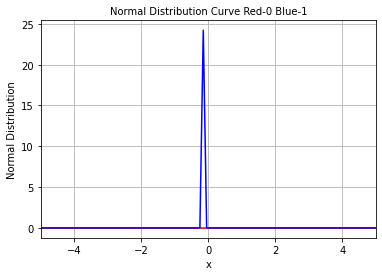

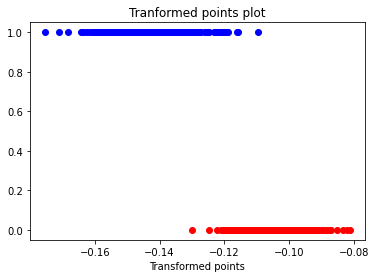

Threshhold after transformation =  (-0.12100662805431121-0j)
Accuracy =  0.9771528998242531
F1-Score =  0.9689737470167064


In [21]:
if __name__=='__main__':
    data=get_data('new_data.csv')
    LDA=Fischer(data,1)
    print("Threshhold after transformation = ",LDA.threshhold)
    print("Accuracy = ",LDA.accuracy)
    print("F1-Score = ",LDA.f_score)